In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive/HW6')

import numpy as np
from tensorflow.keras.datasets import mnist,fashion_mnist
from skimage.util import view_as_windows
from pixelhop import Pixelhop
from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
import time
from sklearn.metrics import confusion_matrix, accuracy_score



np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000     # 50000
N_Test = 10000            # 10000

BS = 2000 # batch size


def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y


def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)

    return selected_images, selected_labels

def Shrink(X, shrinkArg):
    #---- max pooling---- (2x2) -to- (1x1)
    pool = shrinkArg['pool']
    # TODO: fill in the rest of max pooling
    if pool:
        N, H, W, C = X.shape
        if H%2!=0 or W%2!=0:
          print("non even height or width")
        pool_out=np.zeros((N,int(H/2),int(W/2),C),dtype=int)
        for n in range(N):
            for c in range(C):
                for h in range(int(H/2)):
                    for w in range(int(W/2)):
                        pool_out[n,h,w,c]=X[n,h*2:h*2+1,w*2:w*2+1,c].max()
    else:
        pool_out=X

    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch=pool_out.shape[-1]
    # TODO: fill in the rest of neighborhood construction

    if pad>0:
        out=np.pad(pool_out,((0,0), (pad,pad), (pad,pad), (0,0)), 'reflect')
    else:
        out=pool_out
    out = view_as_windows(out, (1, win, win, ch), (1, stride, stride, ch))
    return out.reshape(out.shape[0], out.shape[1], out.shape[2], -1)


# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

def get_feat(X, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output



warnings.filterwarnings("ignore")
# ---------- Load MNIST data and split ----------
(x_train, y_train), _ = mnist.load_data()


# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
#x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
y_train = np.asarray(y_train,dtype='int')
#y_test = np.asarray(y_test,dtype='int')

# if use only 10000 images train pixelhop
#x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

x_train /= 255.0
#x_test /= 255.0
#x_train_reduced /=255.0

# -----------Module 1: set PixelHop parameters-----------
# TODO: fill in this part
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'cw': False},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True}]
shrinkArgs = [{'func':Shrink, 'win':5, 'stride': 1,'pad':2,'pool':False},
            {'func': Shrink, 'win':5, 'stride': 1,'pad':0,'pool':True},
            {'func': Shrink, 'win':5, 'stride': 1,'pad':0,'pool':True}]
concatArg = {'func':Concat}
print("here")
# -----------Module 1: Train PixelHop -----------
# TODO: fill in this part
p2 = Pixelhop(depth=3, TH1=0.005, TH2=0.001,
            SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
p2.fit(x_train)

# --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
# you can get feature "batch wise" and concatenate them if your memory is restricted
# TODO: fill in this part
x_train_feature=[]
x_test_feature=[]
for i in range(int(x_train.shape[0]/BS)):
  train_hop3_feats = get_feat(x_train[2000*i:2000*i+2000]) #get_feat is already set to get 3rd feat
  x_train_feature.append(train_hop3_feats)
  # test_hop3_feats = get_feat(x_test[2000*i:2000*i+2000])
  # x_test_feature.append(test_hop3_feats)

train_hop3_feats=x_train_feature[0]
for i in range(1,int(x_train.shape[0]/BS)):
  train_hop3_feats=np.concatenate((train_hop3_feats,x_train_feature[i]),axis=0)
# test_hop3_feats=np.concatenate((x_test_feature[0],x_test_feature[1],x_test_feature[2],x_test_feature[3],x_test_feature[4]),axis=0)
print("train hop3 feature",train_hop3_feats.shape)
#test_hop3_feats = get_feat(x_test)


# --------- Module 2: standardization
STD = np.std(train_hop3_feats, axis=0, keepdims=1)
train_hop3_feats = train_hop3_feats/STD
#test_hop3_feats = test_hop3_feats/STD

train_hop3_feats = np.reshape(train_hop3_feats,(60000,train_hop3_feats.shape[3]))
#test_hop3_feats = np.reshape(test_hop3_feats,(10000,test_hop3_feats.shape[3]))

#---------- Module 3: Train XGBoost classifier on hop3 feature ---------

tr_acc = []
te_acc = []

clf = xgb.XGBClassifier(n_jobs=-1,
                    objective='multi:softprob',
                    # tree_method='gpu_hist', gpu_id=None,
                    max_depth=6,n_estimators=100,
                    min_child_weight=5,gamma=5,
                    subsample=0.8,learning_rate=0.1,
                    nthread=8,colsample_bytree=1.0)

# train_hop3_feats = np.reshape(train_hop3_feats,(10000,train_hop3_feats.shape[3]))

# test_hop3_feats = np.reshape(test_hop3_feats,(10000,test_hop3_feats.shape[3]))
clf.fit(train_hop3_feats, y_train)

train_pred = clf.predict(train_hop3_feats)
# test_pred = clf.predict(test_hop3_feats)

train_acc = accuracy_score(y_train, train_pred)
#test_acc = accuracy_score(y_test, test_pred)
print("train accuracy",train_acc)
# print("test accuracy",test_acc)


K1=len(p2.Energy["Layer0"])
K2=sum([len(i) for i in p2.Energy["Layer1"]])
K3=sum([len(i) for i in p2.Energy["Layer2"]])
print("K1",K1,"K2",K2,"K3",K3)
print("total number of parameter", 25*(K1+K2+K3))


############################
#failed due to RAM size

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
here


TypeError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive/HW6')

import numpy as np
from tensorflow.keras.datasets import mnist,fashion_mnist
from skimage.util import view_as_windows
from pixelhop import Pixelhop
from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
import time
from sklearn.metrics import confusion_matrix, accuracy_score



np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000     # 50000
N_Test = 10000            # 10000

BS = 2000 # batch size


def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y


def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)

    return selected_images, selected_labels

def Shrink(X, shrinkArg):
    #---- max pooling---- (2x2) -to- (1x1)
    pool = shrinkArg['pool']
    # TODO: fill in the rest of max pooling
    if pool:
        N, H, W, C = X.shape
        if H%2!=0 or W%2!=0:
          print("non even height or width")
        pool_out=np.zeros((N,int(H/2),int(W/2),C),dtype=int)
        for n in range(N):
            for c in range(C):
                for h in range(int(H/2)):
                    for w in range(int(W/2)):
                        pool_out[n,h,w,c]=X[n,h*2:h*2+1,w*2:w*2+1,c].max()
    else:
        pool_out=X

    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch=pool_out.shape[-1]
    # TODO: fill in the rest of neighborhood construction

    if pad>0:
        out=np.pad(pool_out,((0,0), (pad,pad), (pad,pad), (0,0)), 'reflect')
    else:
        out=pool_out
    out = view_as_windows(out, (1, win, win, ch), (1, stride, stride, ch))
    return out.reshape(out.shape[0], out.shape[1], out.shape[2], -1)


# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

def get_feat(X, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output



warnings.filterwarnings("ignore")
# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = mnist.load_data()


# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')

# if use only 10000 images train pixelhop
x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

x_train /= 255.0
x_test /= 255.0
x_train_reduced /=255.0

#TODO:

# train_accuracy=[]
# test_accuracy=[]
# modelSize=[]

# -----------Module 1: set PixelHop parameters-----------
# TODO: fill in this part
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'cw': False},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True}]
shrinkArgs = [{'func':Shrink, 'win':5, 'stride': 1,'pad':2,'pool':False},
            {'func': Shrink, 'win':5, 'stride': 1,'pad':0,'pool':True},
            {'func': Shrink, 'win':5, 'stride': 1,'pad':0,'pool':True}]
concatArg = {'func':Concat}

# -----------Module 1: Train PixelHop -----------
# TODO: fill in this part
p2 = Pixelhop(depth=3, TH1=0.005, TH2=0.001,
            SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
p2.fit(x_train_reduced)

# --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
# you can get feature "batch wise" and concatenate them if your memory is restricted
# TODO: fill in this part
x_train_feature=[]
x_test_feature=[]
for i in range(5):
  train_hop3_feats = get_feat(x_train_reduced[2000*i:2000*i+2000]) #get_feat is already set to get 3rd feat
  x_train_feature.append(train_hop3_feats)
  test_hop3_feats = get_feat(x_test[2000*i:2000*i+2000])
  x_test_feature.append(test_hop3_feats)

train_hop3_feats=np.concatenate((x_train_feature[0],x_train_feature[1],x_train_feature[2],x_train_feature[3],x_train_feature[4]),axis=0)
test_hop3_feats=np.concatenate((x_test_feature[0],x_test_feature[1],x_test_feature[2],x_test_feature[3],x_test_feature[4]),axis=0)

#test_hop3_feats = get_feat(x_test)


# --------- Module 2: standardization
STD = np.std(train_hop3_feats, axis=0, keepdims=1)
train_hop3_feats = train_hop3_feats/STD
test_hop3_feats = test_hop3_feats/STD

train_hop3_feats = np.reshape(train_hop3_feats,(10000,train_hop3_feats.shape[3]))
test_hop3_feats = np.reshape(test_hop3_feats,(10000,test_hop3_feats.shape[3]))

#---------- Module 3: Train XGBoost classifier on hop3 feature ---------

tr_acc = []
te_acc = []

clf = xgb.XGBClassifier(n_jobs=-1,
                    objective='multi:softprob',
                    # tree_method='gpu_hist', gpu_id=None,
                    max_depth=6,n_estimators=100,
                    min_child_weight=5,gamma=5,
                    subsample=0.8,learning_rate=0.1,
                    nthread=8,colsample_bytree=1.0)

# train_hop3_feats = np.reshape(train_hop3_feats,(10000,train_hop3_feats.shape[3]))

# test_hop3_feats = np.reshape(test_hop3_feats,(10000,test_hop3_feats.shape[3]))
clf.fit(train_hop3_feats, y_train_reduced)

train_pred = clf.predict(train_hop3_feats)
test_pred = clf.predict(test_hop3_feats)

train_acc = accuracy_score(y_train_reduced, train_pred)
test_acc = accuracy_score(y_test, test_pred)
print("train accuracy",train_acc)
print("test accuracy",test_acc)


K1=len(p2.Energy["Layer0"])
K2=sum([len(i) for i in p2.Energy["Layer1"]])
K3=sum([len(i) for i in p2.Energy["Layer2"]])
print("K1",K1,"K2",K2,"K3",K3)
print("total number of parameter", 25*K1+25*K1*K2+25*K2*K3)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
train accuracy 0.9701
test accuracy 0.9168
K1 1 K2 134 K3 111
total number of parameter 375225


[[985   0   1   0   2   5   1   0   6   0]
 [  0 985   6   0   1   1   1   3   3   0]
 [  0   2 970   2   2   2   5   8   6   3]
 [  1   1   9 961   0  15   0   6   4   3]
 [  0   1   1   0 966   0   8   1   1  22]
 [  1   3   3  10   4 975   1   0   2   1]
 [  4   0   0   0   3   3 987   0   3   0]
 [  0   1   4   0   4   2   0 972   4  13]
 [  2   6   5   6   2  12   4   4 955   4]
 [  7   2   1   4  18   5   3   9   6 945]]
[[0.0985 0.     0.0001 0.     0.0002 0.0005 0.0001 0.     0.0006 0.    ]
 [0.     0.0985 0.0006 0.     0.0001 0.0001 0.0001 0.0003 0.0003 0.    ]
 [0.     0.0002 0.097  0.0002 0.0002 0.0002 0.0005 0.0008 0.0006 0.0003]
 [0.0001 0.0001 0.0009 0.0961 0.     0.0015 0.     0.0006 0.0004 0.0003]
 [0.     0.0001 0.0001 0.     0.0966 0.     0.0008 0.0001 0.0001 0.0022]
 [0.0001 0.0003 0.0003 0.001  0.0004 0.0975 0.0001 0.     0.0002 0.0001]
 [0.0004 0.     0.     0.     0.0003 0.0003 0.0987 0.     0.0003 0.    ]
 [0.     0.0001 0.0004 0.     0.0004 0.0002 0.     0.0972 

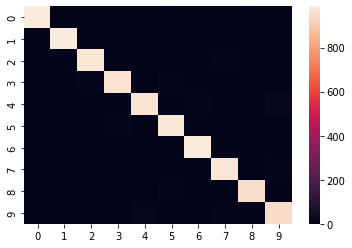

In [3]:
cm=confusion_matrix(y_train_reduced,train_pred)
print(cm)
print(cm/10000)
import seaborn as sns
sns.heatmap(cm)
